# LSTM

# IMDB 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras

import random
def set_seed(seed = 42):
  tf.keras.utils.set_random_seed(seed)
  tf.config.experimental.enable_op_determinism()

set_seed(42)

In [2]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
max_len = 100

In [5]:
# ↓ 각 샘플의 길이를 100에 맞추고 부족할때는 패딩을 추가
train_seq = pad_sequences(train_input, maxlen=max_len)
val_seq = pad_sequences(val_input, maxlen=max_len)
test_seq = pad_sequences(test_input, maxlen=max_len)

In [6]:
train_seq.shape, val_seq.shape, test_seq.shape

((20000, 100), (5000, 100), (25000, 100))

# ■ LSTM

**tf.keras.layers.LSTM**

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

```python
tf.keras.layers.LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    use_cudnn='auto',
    **kwargs
)
```

In [7]:
model = keras.Sequential()

model.add(keras.layers.Input(shape=(max_len,)))  # (100,)
model.add(keras.layers.Embedding(input_dim=500, output_dim=16))
model.add(keras.layers.LSTM(units=8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""
Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         8,000 │


│ lstm (LSTM)                     │ (None, 8)              │           800 │
          # parameter 개수
          # ① 입력 parameter  :  16 input x 8 units = 128개
          # ② 은닉상태 parameter : 8 units x 8 units = 64개
          # ③ bias : 8 units 개

          # ④ : ① + ② + ③ = 200개

          # 전체 parameter 는
          #  4 x ④200개 => 800개
          #  ↑ 4 는 LSTM 셀 내의 각 게이트 (입력 게이트, 출력 게이트, 포겟 게이트, 셀 상태 업데이트)
          #    에 해당하는 파라미터의 개수

        ★LSTM의 파라미터 개수★
            => 4gates x units x (units + inputs + 1)
            => ex) 4 x 8 x (8 + 16 + 1) => 800

│ dense (Dense)                   │ (None, 1)              │             9 │



 Total params: 8,809 (34.41 KB)
 Trainable params: 8,809 (34.41 KB)
 Non-trainable params: 0 (0.00 B)
"""
None

## 훈련

In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best-lstm-model.keras',
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5110 - loss: 0.6929 - val_accuracy: 0.5864 - val_loss: 0.6911
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5784 - loss: 0.6907 - val_accuracy: 0.6258 - val_loss: 0.6874
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6217 - loss: 0.6858 - val_accuracy: 0.6562 - val_loss: 0.6765
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6681 - loss: 0.6682 - val_accuracy: 0.7096 - val_loss: 0.6177
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7180 - loss: 0.6006 - val_accuracy: 0.7248 - val_loss: 0.5760
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7282 - loss: 0.5690 - val_accuracy: 0.7404 - val_loss: 0.5555
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7481 - loss: 0.5465 - val_accuracy: 0.7450 - val_loss: 0.5383
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7600 - loss: 0.5274 - val_accu

In [9]:
early_stopping_cb.best_epoch

48

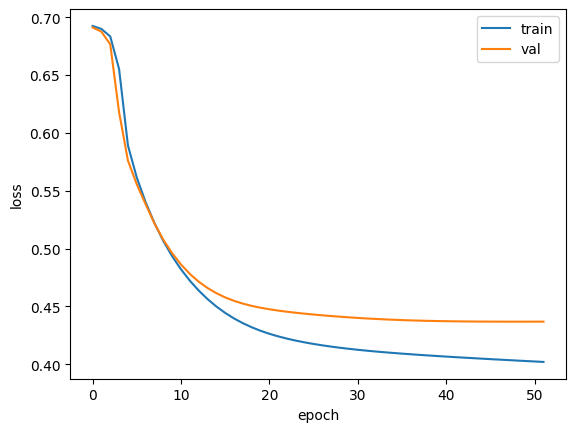

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# ■ 순환 층에 드롭 아웃 적용

In [ ]:
# 완전연결신경망과 CNN 에서는 Dropout 클래스를 사용해서 dropout 을 적용했었다
# 순환층은 '자체적으로 dropout 기능을 제공'

# SimpleRNN, LSTM 클래스에 제공하는 2개의 dropout= 매개변수
#   dropout= : 셀의 '입력'에 dropout 적용
#   recurrent_dropout= : 순환되는 '은닉상태'에 dropout 적용
#                        ※ recurrent_dropout 는 GPU를 통한 훈련 못함..

In [11]:
model2 = keras.Sequential()
model2.add(keras.layers.Input(shape=(max_len,)))
model2.add(keras.layers.Embedding(input_dim=500, output_dim=16))
model2.add(keras.layers.LSTM(units=8, dropout=0.3)) # dropout 30%
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [12]:
# 이전과 동일한 조건으로 훈련해보자 (저장 파일명만 변경)
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best-dropout-model.keras',
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history2 = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5145 - loss: 0.6930 - val_accuracy: 0.5716 - val_loss: 0.6922
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5619 - loss: 0.6920 - val_accuracy: 0.6068 - val_loss: 0.6908
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6026 - loss: 0.6902 - val_accuracy: 0.6288 - val_loss: 0.6879
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6257 - loss: 0.6865 - val_accuracy: 0.6490 - val_loss: 0.6809
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6458 - loss: 0.6773 - val_accuracy: 0.6560 - val_loss: 0.6494
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6848 - loss: 0.6394 - val_accuracy: 0.7270 - val_loss: 0.5991
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7198 - loss: 0.5997 - val_accuracy: 0.7404 - val_loss: 0.5803
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7326 - loss: 0.5804 - val_accu

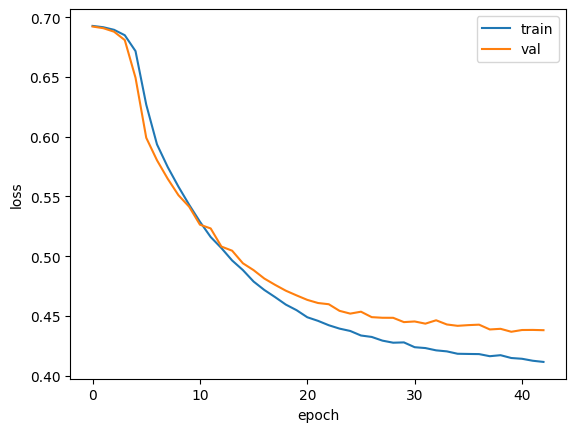

In [13]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# ■ 순환층 2개 연결하기
### 순환층 연결시 주의!
- 순환층의 은닉상태는 샘플의 마지막 스텝에 대한 은닉 상태만 다음층으로 전달한다
- 그러나, 순환층을 쌓게 되면 모든 순환층에는 순차 데이터가 필요하다.
- 따라서
    - 앞쪽의 순환층은 '모든 타임스텝'에 대한 은닉상태를 출력해야 하고,
    - 마지막 순환층만 '마지막 타임스텝의 은닉상태'를 출력해야 한다

## return_sequences=True
모든 타임스텝에 대한 은닉상태 출력 (2차원 출력)

In [14]:
model3 = keras.Sequential()
model3.add(keras.layers.Input(shape=(max_len,)))
model3.add(keras.layers.Embedding(input_dim=500, output_dim=16))
model3.add(keras.layers.LSTM(units=8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(units=8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""
Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 16)        │         8,000 │

│ lstm_2 (LSTM)                   │ (None, 100, 8)         │           800 │
      # [출력크기]
      # 첫번째 LSTM 층이 모든 타임스텝(100개) 의 은닉상태를 출력하기 때문에
      # 출력크기가 (?, 100, 8) 로 출력됨 (2차원 출력)

        # [첫번째 LSTM 의 parameter]
            => 4gates x units x (units + inputs + 1)
            => ex) 4 x 8 x (8 + 16 + 1) => 800

│ lstm_3 (LSTM)                   │ (None, 8)              │           544 │
      #  [출력 크기]
      # 마지막 LSTM 층의 출력크기는 마지막 타임스텝의 은닉상태만 출력하기 때문에
      # 출력크기가 (?, 8) 이다.

        # [두번째 LSTM 의 parameter]
        # 두 번째 LSTM의 경우, '첫 번째 LSTM의 출력'이 '두 번째 LSTM의 입력'이 됩니다.
        # 따라서 두 번째 LSTM의 입력 피처 수는 첫 번째 LSTM의 유닛 수와 동일
            => units x (units + inputs + 1)
            => ex) 4gates x 8 x (8 + 8 + 1) => 544


│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 9,353 (36.54 KB)
 Trainable params: 9,353 (36.54 KB)
 Non-trainable params: 0 (0.00 B)
"""
None

## 훈련

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
          'best-2rnn-model.keras',
          save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history3 = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5235 - loss: 0.6927 - val_accuracy: 0.5964 - val_loss: 0.6907
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5854 - loss: 0.6888 - val_accuracy: 0.6470 - val_loss: 0.6764
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6495 - loss: 0.6604 - val_accuracy: 0.7104 - val_loss: 0.5774
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7134 - loss: 0.5717 - val_accuracy: 0.7346 - val_loss: 0.5318
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7405 - loss: 0.5346 - val_accuracy: 0.7580 - val_loss: 0.5051
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7571 - loss: 0.5090 - val_accuracy: 0.7616 - val_loss: 0.4972
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7712 - loss: 0.4930 - val_accuracy: 0.7654 - val_loss: 0.4921
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7732 - loss: 0.4813 - 

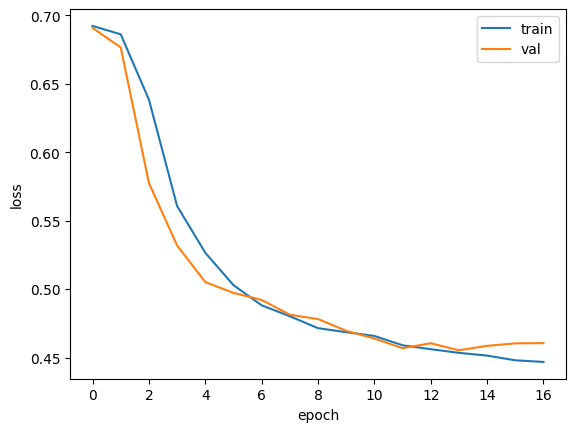

In [16]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# ■ GRU 신경망
Gated Recurrent Unit

https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

```python
tf.keras.layers.GRU(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    reset_after=True,
    use_cudnn='auto',
    **kwargs
)
```

In [17]:
model4 = keras.Sequential()

model4.add(keras.layers.Input(shape=(max_len,)))  # (100,)
model4.add(keras.layers.Embedding(input_dim=500, output_dim=16))
model4.add(keras.layers.GRU(units=8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""
Model: "sequential_3"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │

│ gru (GRU)                       │ (None, 8)              │           624 │
    # parameter 개수
    #  GRU 셀에는 3개의 작은 셀이 있다.
    #  각 작은 셀에는 '입력'과 '은닉상태(h)'에 곱하는 weight 와 bias 가 있다.
    #  '입력' 에 곱하는 weight 는 16 * 8 = 128개
    #  '은닉상태' 에 곱하는 weigths 는 8 * 8 = 64개
    #  'bias' 는 뉴런마다 하나씩 => 8개
    #  모두 더하면 128 + 64 + 8 => 200개
    #  이런 작은 셀이 3개 있다 200 * 3 => 600개

    # TF GRU 는 내부적으로 작은 셀마다 하나의 bias 가 추가된다.
    #   작은셀 3개 x 8개 units => 24개


│ dense_3 (Dense)                 │ (None, 1)              │             9 │

 Total params: 8,633 (33.72 KB)
 Trainable params: 8,633 (33.72 KB)
 Non-trainable params: 0 (0.00 B)
"""
None

## 훈련

In [18]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best-gru-model.keras',
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history4 = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5052 - loss: 0.6931 - val_accuracy: 0.5206 - val_loss: 0.6928
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5532 - loss: 0.6925 - val_accuracy: 0.5616 - val_loss: 0.6921
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5831 - loss: 0.6917 - val_accuracy: 0.5714 - val_loss: 0.6911
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5901 - loss: 0.6903 - val_accuracy: 0.5844 - val_loss: 0.6893
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6033 - loss: 0.6882 - val_accuracy: 0.5938 - val_loss: 0.6866
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6136 - loss: 0.6849 - val_accuracy: 0.6036 - val_loss: 0.6822
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6197 - loss: 0.6796 - val_accuracy: 0.6120 - val_loss: 0.6752
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6300 - loss: 0.6713 - val_accu

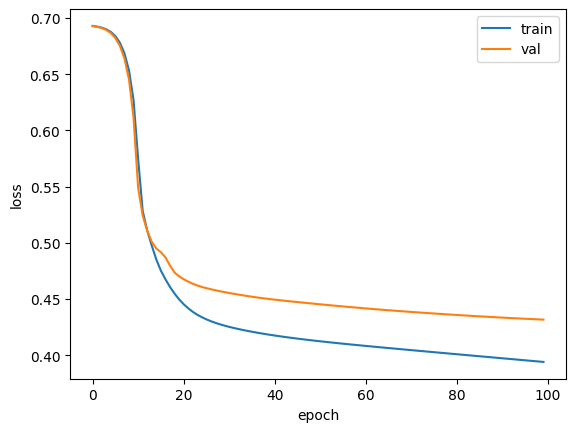

In [19]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# ■ 양방향 LSTM
Bidirectional-LSTM, Bi-LSTM
RNN 이나 LSTM 은 일반 신경망과 다르게 시퀀스 또는 시계열 데이터 처리에 특화되어 은닉층에서 과거의 정보를 기억할 수 있습니다.  그러나, 순환 신경망의 구조적 특성상 데이터가 **'입력 순'** 으로 처리되기 때문에 이전 시점의 정보만 활용할 수 밖에 없는 단점이 존재합니다.  문장이 길어 질수록(시퀀스가 길어질수록) 성능이 저하될 수 밖에 없습니다. 다음 예문을 봅시다

> ios 앱 <u>[   ]</u>은 맥북이 필요합니다

> ios 앱 <u>개발</u>은 맥북이 필요합니다

한국어를 사용하는 우리에겐 어렵지 않게 빈칸에 들어가는 단어를 유추해낼수 있다.  그러나 일반적인 RNN 이나 LSTM 에서 순차적으로 입력되는 시퀀스를 통해 앞에 입력된 데이터인 'ios' 와 '앱' 이라는 단어만 가지고 빈칸에 들어갈 '개발' 이라는 단어를 유추해 내기엔 정보가 매우 부족하다.

문장 **앞부분보단, 뒷부분에 중요한 정보**가 존재하기 때문입니다.

따라서! 자연어 처리에서 입력 데이터의 '정방향' 처리만큼 **'역방향'** 처리도 중요합니다!

**양방향 LSTM (Bidirectional LSTM)** 은 기존 LSTM 계측에 역방향으로 처리하는  LSTM 계층을 하나 더 추가해 양방향에서 문장의 패턴을 분석할수 있도록 구성되어 있습니다.  입력 문장을 양방향에서 처리하므로 시퀀스 길이가 길어진다 하더라도 정보 손실 없이 처리가 가능


**양방향 LSTM 구조**

![](https://blog.kakaocdn.net/dn/ySdrH/btrZrwllBAV/T6RqmCYAkavMJ1iZ2gTi80/img.png)

## Bidirectional
**tf.keras.layers.Bidirectional**
- RNN 에 적용하는 양방향 (bidirectional) wrapper
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
- Bidirectional 로 설정할 RNN layer 는 **return_sequences=True**: 모든 time step 에서 출력을 반환해야 하므로 설정해야 한다

```python
tf.keras.layers.Bidirectional(
    layer,
    merge_mode='concat',
    weights=None,
    backward_layer=None,
    **kwargs
)
```





## TimeDistributed
**tf.keras.layers.TimeDistributed**
- 각 time step 에서 출력된 output 을 내부에 선언해준 레이어와 연결시켜주는 역할
- TimeDistributed 또한 Wrapper 다 (Wrapper 상속객체)
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed
- 출력 형태는 (batch_size, time_steps, num_classes)

```python
tf.keras.layers.TimeDistributed(
    layer, **kwargs
)
```



양방향 LSTM 모델을 정의할때 주의점!
- 정방향, 역방향 LSTM 계측 모두 출력값을 연결해야 하기 때문에, return_sequences= 인자를 반드시 True 로 해야 함.
- 또한 Dense 계층을 TimeDistributed 래퍼를 사용해 3차원 텐서를 입력받을수 있게 확장해야 한다


## 모델 정의

In [23]:
from tensorflow.keras.layers import Bidirectional, TimeDistributed, Flatten, \
                            Input, LSTM, Embedding, Dense

In [24]:
model5 = keras.Sequential()

model5.add(Input(shape=(max_len,)))
model5.add(Embedding(input_dim=500, output_dim=16))
model5.add(Bidirectional(LSTM(8, dropout=0.3, return_sequences=True)))
model5.add(TimeDistributed(Dense(1, activation='sigmoid')))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 16)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 1)         │            17 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,718 (37.96 KB)

 Trainable params: 9,718 (37.96 KB)

 Non-trainable params: 0 (0.00 B)

## 훈련

In [25]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model5.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
          'best-biLSTM-model.keras',
          save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history5 = model5.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4970 - loss: 0.6949 - val_accuracy: 0.5148 - val_loss: 0.6931
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4977 - loss: 0.6932 - val_accuracy: 0.5186 - val_loss: 0.6930
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5024 - loss: 0.6931 - val_accuracy: 0.5162 - val_loss: 0.6929
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5038 - loss: 0.6930 - val_accuracy: 0.5162 - val_loss: 0.6929
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5069 - loss: 0.6930 - val_accuracy: 0.5202 - val_loss: 0.6928
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5104 - loss: 0.6928 - val_accuracy: 0.5180 - val_loss: 0.6927
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5107 - loss: 0.6927 - val_accuracy: 0.5200 - val_loss: 0.6926
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5119 - loss: 0.6926 -

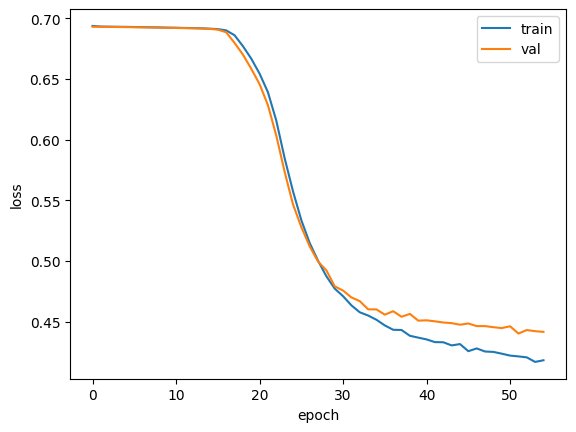

In [26]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()